# Lab 2 #
## The Dijkstra’s Algorithm ##

We shall create a graph for this project and create helper functions 

In [1]:
G = {
    "A": [("B", 2), ("D", 4), ("E", 7)],
    "B": [("C", 3), ("E", 1), ("F", 4)],
    "C": [("F", 2)],
    "D": [("E", 5)],
    "E": [("F", 6)],
    "F": []
}


def get_neighbours(graph, v): #get the neighbour of vertex v from the graph
    return graph[v]

def get_total_nodes(graph): #get the total number of nodes in the graph
    return len(graph)


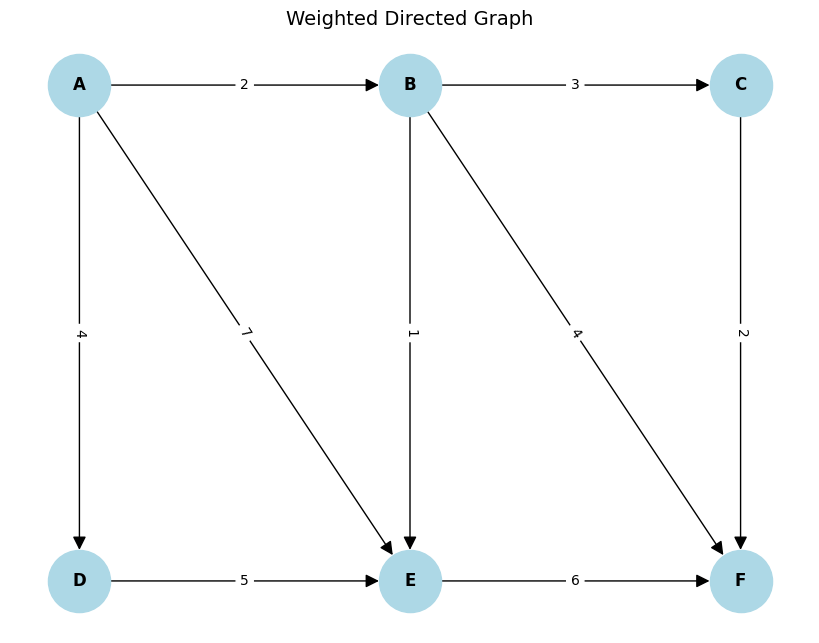

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

Graph = nx.DiGraph()

# Add edges with weights
for u, neighbors in G.items():
    for v, w in neighbors:
        Graph.add_edge(u, v, weight=w)

pos = {
    "A": (0, 2),
    "B": (2, 2),
    "C": (4, 2),
    "D": (0, 0),
    "E": (2, 0),
    "F": (4, 0),
}

plt.figure(figsize=(8, 6))

# Draw nodes and edges
nx.draw(Graph, pos, with_labels=True, node_size=2000, node_color="lightblue",
        font_size=12, font_weight="bold", arrowsize=20)
nx.draw_networkx_edge_labels(Graph, pos, edge_labels=nx.get_edge_attributes(Graph, "weight"), font_size=10)

plt.title("Weighted Directed Graph", fontsize=14)
plt.axis("off")
plt.show()

### Implementing a priority queue using an array ###

In [3]:
class PriorityQueue_array:
    def __init__(self):
        self.elements = [] #this is going to stpre tuples containing (node,dist)

    def is_empty(self):
        return  len(self.elements) == 0

    def put(self, item):
        self.elements.append(item)

    def pop(self):
        min = 0 #holds the index of the node with the smallest distance
        for i in range(1, len(self.elements)):
            if self.elements[i][1]< self.elements[min][1]: #compares the distance of the nodes O(V)
                min = i
        min_node = self.elements[min]
        del self.elements[min] #removes the node with the smallest distance from the list
        return min_node

In [4]:
pq = PriorityQueue_array() #testing
pq.put(('A', 5))
pq.put(('B', 3))
pq.put(('C', 8))

print(pq.pop()) #should return ('B', 3)
print(pq.pop()) #should return ('A', 5)
print(pq.pop()) #should return ('C', 8)
print(pq.is_empty()) #should return True

('B', 3)
('A', 5)
('C', 8)
True


## Part 1: Using an array for the priority queue ##

In [5]:
def dijkstra_using_array(graph, start):
    d={node : float("inf") for node in graph.keys()} #to store the shortest distance from source to each node
    pi = {node :None for node in graph.keys()} # to hold the predecessor of each node
    visited = set() # to hold the visited nodes
    pq = PriorityQueue_array() #priority queue implemented using an array
    pq.put((start,0))
    d[start] = 0
    while not pq.is_empty() and len(visited) < get_total_nodes(graph): #Total V nodes
        current, curr_dist = pq.pop() #using an array to get the node with the smallest distance O(V)
        if current in visited:
            continue
        else:
            visited.add(current)
            for neighbour, weight in get_neighbours(graph, current): #relaxes edges O(E)
                if neighbour not in visited:
                    if d[current] + weight < d[neighbour]:
                        d[neighbour] = d[current] + weight #updates the distance to the neighbour O(1)
                        pi[neighbour] = current
                        pq.put((neighbour, d[neighbour])) #push the shorter distance node to the priority queue O(1)
    return d, pi, visited   

In [6]:
dijkstra_using_array(G, "A")

({'A': 0, 'B': 2, 'C': 5, 'D': 4, 'E': 3, 'F': 6},
 {'A': None, 'B': 'A', 'C': 'B', 'D': 'A', 'E': 'B', 'F': 'B'},
 {'A', 'B', 'C', 'D', 'E', 'F'})

In [7]:
import random, time
from collections import defaultdict

time_taken_result_for_dense = []
input_sizes = [20, 50, 100, 200, 500, 1000, 2000, 3500, 5000]

def generate_dense_matrix(V, edge_prob=0.3, max_weight=10): #v is the number of vertices
    num_of_edge = 0
    graph = defaultdict(list)
    for i in range(V):
        for j in range(V):
            if i != j and random.random() > edge_prob: #70% chance of creating edges
                graph[i].append((j, random.randint(1, max_weight))) #edge to j with random weight from 1 to 10 created
                num_of_edge += 1
    return graph, num_of_edge

for V in input_sizes:
    Dense_Graph, edge_count = generate_dense_matrix(V)
    start = time.time()
    dijkstra_using_array(Dense_Graph, 0)
    end = time.time()
    time_taken = end - start
    time_taken_result_for_dense.append(((V,edge_count), f"{time_taken:.8f}"))



In [8]:
time_taken_result_for_dense

[((20, 272), '0.00000000'),
 ((50, 1710), '0.00321937'),
 ((100, 6975), '0.00530028'),
 ((200, 27796), '0.02292013'),
 ((500, 174351), '0.15318179'),
 ((1000, 699482), '0.69501281'),
 ((2000, 2797516), '2.56782508'),
 ((3500, 8571320), '7.91080332'),
 ((5000, 17494393), '15.88017464')]

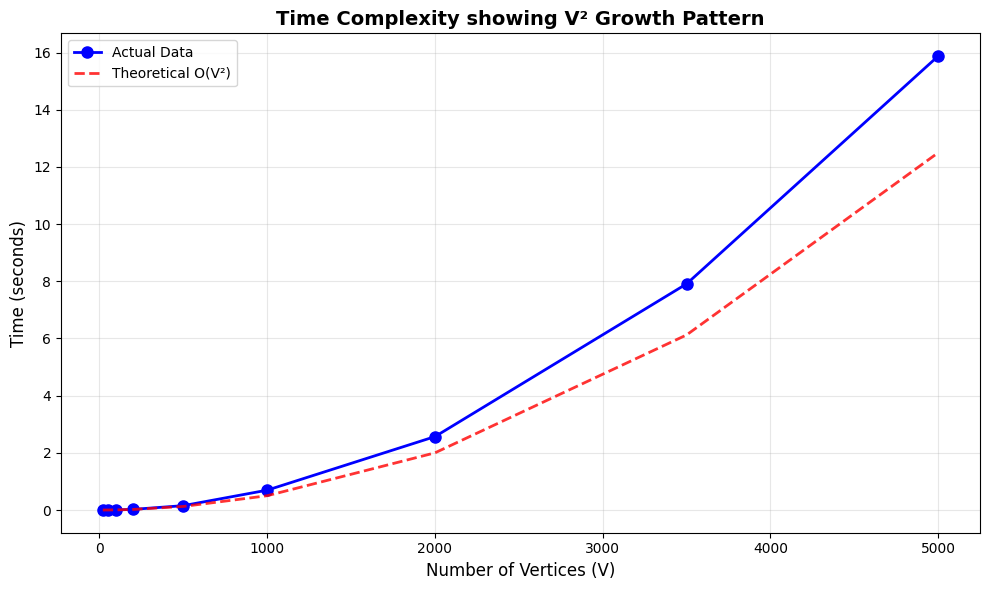

In [10]:
import matplotlib.pyplot as plt
import numpy as np

V_values = [item[0][0] for item in time_taken_result_for_dense]
time_values = [float(item[1]) for item in time_taken_result_for_dense]

#Create the plot
plt.figure(figsize=(10, 6))
plt.plot(V_values, time_values, 'b-o', linewidth=2, markersize=8, label='Actual Data') #actual

V_theoretical = np.array(V_values)
theoretical_times = (V_theoretical ** 2) * 0.0000005
plt.plot(V_theoretical, theoretical_times, 'r--', linewidth=2, 
         label='Theoretical O(V²)', alpha=0.8)
plt.xlabel('Number of Vertices (V)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time Complexity showing V² Growth Pattern', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Dijkstra's Algorithm Complexity Analysis ###
1. Finding the Minimum Distance Node Among Unvisited Nodes

`current, curr_dist = pq.pop()`
- Complexity Breakdown: pq has at most |V| nodes (where |V| is the number of vertices)
- in the pop() function we have:
`for i in range(1, len(self.elements)):`
            `if self.elements[i][1]< self.elements[min][1]:`
                `min = i`
- This operation scans through all unvisited nodes → O(|V|) time per operation
- This operation is performed once per vertex (|V| times total)

Total complexity for this operation: O(|V|²)


2. Relaxing All Outgoing Edges from Current Node

`for neighbour, weight in get_neighbours(graph, current):`
Complexity Breakdown:
- Across the entire algorithm, every edge (u, v) ∈ E is relaxed exactly once
- Total work for all edge relaxations: O(|E|) (where |E| is the number of edges)



Total Algorithm Complexity
- O(|V|² + |E|)
- Max possible edges = $∣V∣⋅(∣V∣−1)≈∣V∣^2$ (where V is the total number of vertex and each of them can have a maximum of V-1 edges, when it is joined to all other vertex)
- If the graph is dense (close to complete): |E| ≈ |V|² →
⇒ O(|V|² + |V|²) = O(|V|²).


Comparison with theoratical $O(|V|^2)$
- Our graphs shows similar time complexity in terms of slope confirming the quadratic complexity
- Empirical analysis shows our graph is slightly higher than the theoratical times since our graph is dense with each node having a 70% chance of having a edge with other nodes
- Thus we have $O(|V|² + |E|)$ ≈ $O(|V|² + 0.7|V|²)$  >  $O(|V|²)$

In [11]:
import random, time
from collections import defaultdict

time_taken_result_for_sparse = []
input_sizes = [20, 50, 100, 200, 500, 1000, 2000, 3500, 5000]

def generate_sparse_matrix(V, edge_prob=0.7, max_weight=10): #v is the number of vertices
    num_of_edge = 0
    graph = defaultdict(list)
    for i in range(V):
        for j in range(V):
            if i != j and random.random() > edge_prob: #30% chance of creating edges
                graph[i].append((j, random.randint(1, max_weight))) #edge to j with random weight from 1 to 10 created
                num_of_edge += 1
    return graph, num_of_edge

for V in input_sizes:
    Sparse_Graph, edge_count = generate_sparse_matrix(V)
    start = time.time()
    dijkstra_using_array(Sparse_Graph, 0)
    end = time.time()
    time_taken = end - start
    time_taken_result_for_sparse.append(((V,edge_count), f"{time_taken:.8f}"))

In [12]:
time_taken_result_for_sparse

[((20, 108), '0.00000000'),
 ((50, 764), '0.00202012'),
 ((100, 2987), '0.00404453'),
 ((200, 11909), '0.02014041'),
 ((500, 74911), '0.12932014'),
 ((1000, 299600), '0.54354501'),
 ((2000, 1200432), '2.07345200'),
 ((3500, 3673275), '7.23343635'),
 ((5000, 7496461), '16.70198894')]

Comparison with theoratical $O(|V|^2)$
- Our graphs shows similar time complexity in terms of slope confirming the quadratic complexity
- Empirical analysis shows our graph is very similar to the theoratical times since our graph is sparser with each node having a 30% chance of having a edge with other nodes
- Thus we have $O(|V|² + |E|)$ ≈ $O(|V|² + 0.3|V|²)$ ≈ $O(|V|²)$

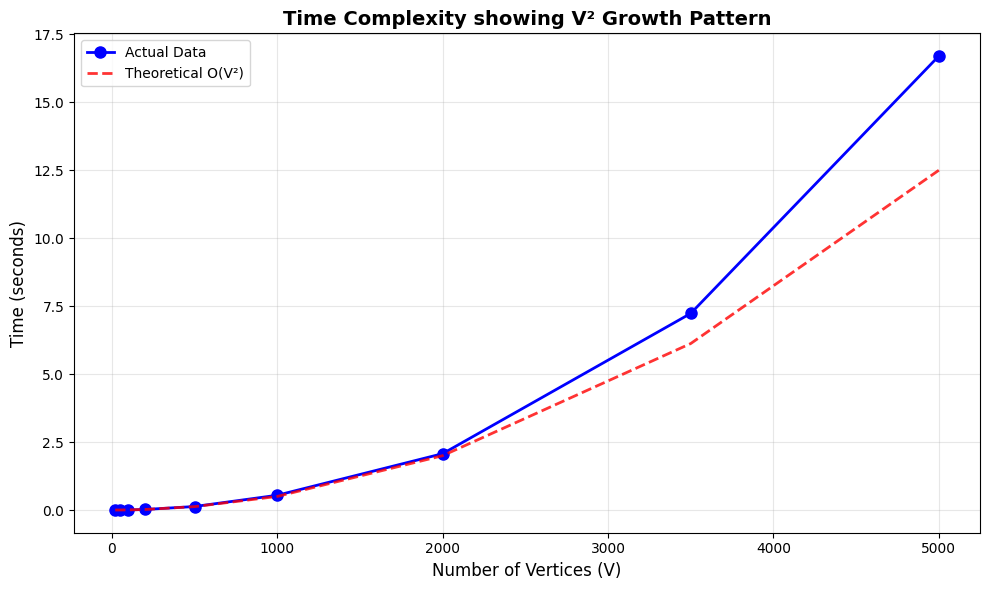

In [13]:
import matplotlib.pyplot as plt
import numpy as np

V_values = [item[0][0] for item in time_taken_result_for_sparse]
time_values = [float(item[1]) for item in time_taken_result_for_sparse]

#Create the plot
plt.figure(figsize=(10, 6))
plt.plot(V_values, time_values, 'b-o', linewidth=2, markersize=8, label='Actual Data') #actual
V_theoretical = np.array(V_values)
theoretical_times = (V_theoretical ** 2) * 0.0000005
plt.plot(V_theoretical, theoretical_times, 'r--', linewidth=2, 
         label='Theoretical O(V²)', alpha=0.8)
plt.xlabel('Number of Vertices (V)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time Complexity showing V² Growth Pattern', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Part B ###

- We now use a minimising heap for the priority queue, to visit/select the node with the shortest distance to the source node

In [8]:
import heapq

min_heap1 = [(0, "0")]
heapq.heappush(min_heap1, (4, "1"))
heapq.heappush(min_heap1, (6, "2"))
heapq.heappush(min_heap1, (3, "3"))
heapq.heappush(min_heap1, (2, "2"))
print(heapq.heappop(min_heap1))
print(heapq.heappop(min_heap1))
print(heapq.heappop(min_heap1)) 
print(heapq.heappop(min_heap1))
print(heapq.heappop(min_heap1))
 


(0, '0')
(2, '2')
(3, '3')
(4, '1')
(6, '2')


In [14]:
import heapq

def dijkstra_using_min_heap(graph, start):
    d={node : float("inf") for node in graph.keys()} #to store the shortest distance from source to each node
    pi = {node :None for node in graph.keys()} # to hold the predecessor of each node
    visited = set() # to hold the visited nodes

    d[start] = 0

    min_heap = [(0, start)]  # put the first (distance, node) tuples
    while min_heap and len(visited)< get_total_nodes(graph): #Total V nodes
        current_dist, curr = heapq.heappop(min_heap) #this will give me the node with the smallest distance O(log V)
        if curr in visited:
            continue
        else: #havent visit before
            visited.add(curr)
            for neighbour, weight in get_neighbours(graph, curr):
                if neighbour not in visited: #only process edges to unvisited nodes
                    if d[curr] + weight < d[neighbour]:
                        d[neighbour] = d[curr] + weight
                        pi[neighbour] = curr
                        heapq.heappush(min_heap, (d[neighbour], neighbour)) #push the shorter distance node to the min-heap, O(log V)
    
    return d, pi, visited

### Dijkstra's Algorithm with min heap complexity Analysis ###
1. Finding the Minimum Distance Node Among Unvisited Nodes

`current, curr_dist = heapq.heappop(min_heap)`
- Complexity Breakdown: heapq has a height of log(V) 
- After removal of min node, the replacement node will take at most log|V| steps to maintain min heap condition(where |V| is the number of vertices)
- This operation is performed once per vertex (|V| times total)

Total complexity for this operation: O(Vlog(|V|))


2. Relaxing All Outgoing Edges from Current Node

`for neighbour, weight in get_neighbours(graph, current):`
`heapq.heappush(min_heap, (d[neighbour], neighbour))`
Complexity Breakdown:
- New edges with shorter distance from source node is added to the heapq
- Across the entire algorithm, every edge (u, v) ∈ E is added to the heapq in the worst case
- Each edge travels at worst log(V) levels to maintain min heap condition
- Total work for all edge relaxations: O(|E log(V)) (where E is the number of edges)



Total algorithm complexity
- O(|V| log |V| + |E| log |V|) = O((|V| + |E|) log |V|).
- Sparse graphs (|E| ≪ |V|²): O(|E| log |V|) dominates; the heap version is significantly faster than O(|V|²).
- Dense graphs (|E| ≈ |V|²): O(|V|² log |V|). Despite the extra log factor vs. array-based O(|V|²), heaps are often faster in practice due to lower constant factors and superior memory behavior.

In [21]:
import random, time
from collections import defaultdict

time_taken_result_for_dense_heap = []
input_sizes = [20, 50, 100, 200, 500, 1000, 2000, 3500, 5000]

for V in input_sizes:
    Dense_Graph, edge_count = generate_dense_matrix(V)
    start = time.time()
    dijkstra_using_min_heap(Dense_Graph, 0)
    end = time.time()
    time_taken = end - start
    time_taken_result_for_dense_heap.append(((V,edge_count), f"{time_taken:.8f}"))



In [22]:
time_taken_result_for_dense_heap

[((20, 273), '0.00555015'),
 ((50, 1734), '0.00000000'),
 ((100, 6997), '0.00178599'),
 ((200, 27796), '0.01010776'),
 ((500, 174780), '0.03698969'),
 ((1000, 699762), '0.09944820'),
 ((2000, 2800148), '0.44197512'),
 ((3500, 8572065), '1.93037009'),
 ((5000, 17495733), '4.42569613')]

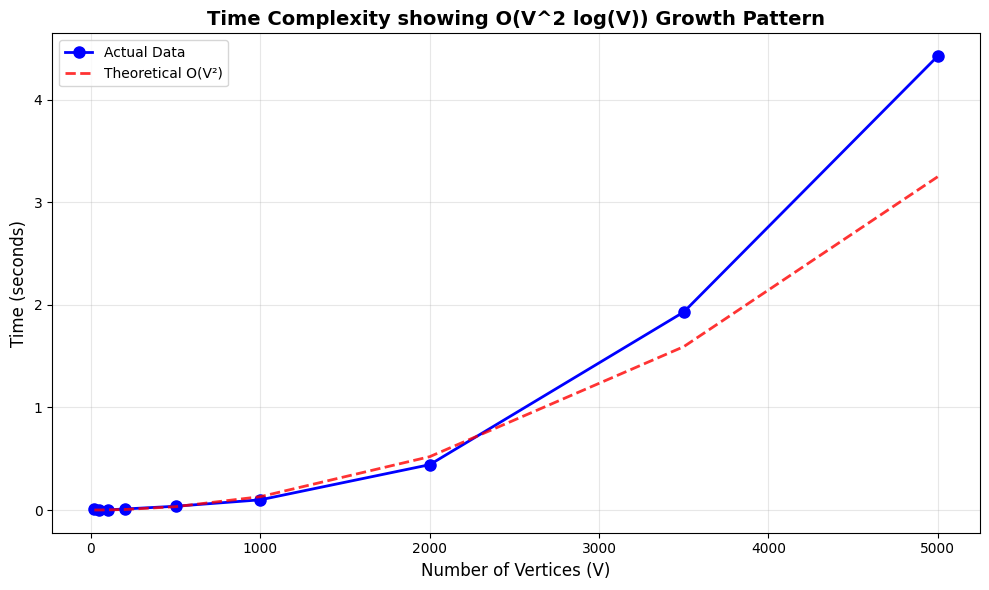

In [24]:

V_values = [item[0][0] for item in time_taken_result_for_dense_heap]
time_values = [float(item[1]) for item in time_taken_result_for_dense_heap]

#Create the plot
plt.figure(figsize=(10, 6))
plt.plot(V_values, time_values, 'b-o', linewidth=2, markersize=8, label='Actual Data') #actual

V_theoretical = np.array(V_values)
theoretical_times = (V_theoretical ** 2) * 0.00000013
plt.plot(V_theoretical, theoretical_times, 'r--', linewidth=2, 
         label='Theoretical O(V²)', alpha=0.8)
plt.xlabel('Number of Vertices (V)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time Complexity showing O(V^2 log(V)) Growth Pattern', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
time_taken_result_for_sparse_heap = []
input_sizes = [20, 50, 100, 200, 500, 1000, 2000, 3500, 5000]

for V in input_sizes:
    Sparse_Graph, edge_count = generate_sparse_matrix(V)
    start = time.time()
    dijkstra_using_min_heap(Sparse_Graph, 0)
    end = time.time()
    time_taken = end - start
    time_taken_result_for_sparse_heap.append(((V,edge_count), f"{time_taken:.8f}"))

In [20]:
time_taken_result_for_sparse_heap

[((20, 108), '0.00000000'),
 ((50, 721), '0.00000000'),
 ((100, 3066), '0.00106120'),
 ((200, 11974), '0.00538969'),
 ((500, 74948), '0.01751733'),
 ((1000, 299788), '0.06108236'),
 ((2000, 1199808), '0.25995445'),
 ((3500, 3675202), '0.75040698'),
 ((5000, 7498502), '1.65938807')]

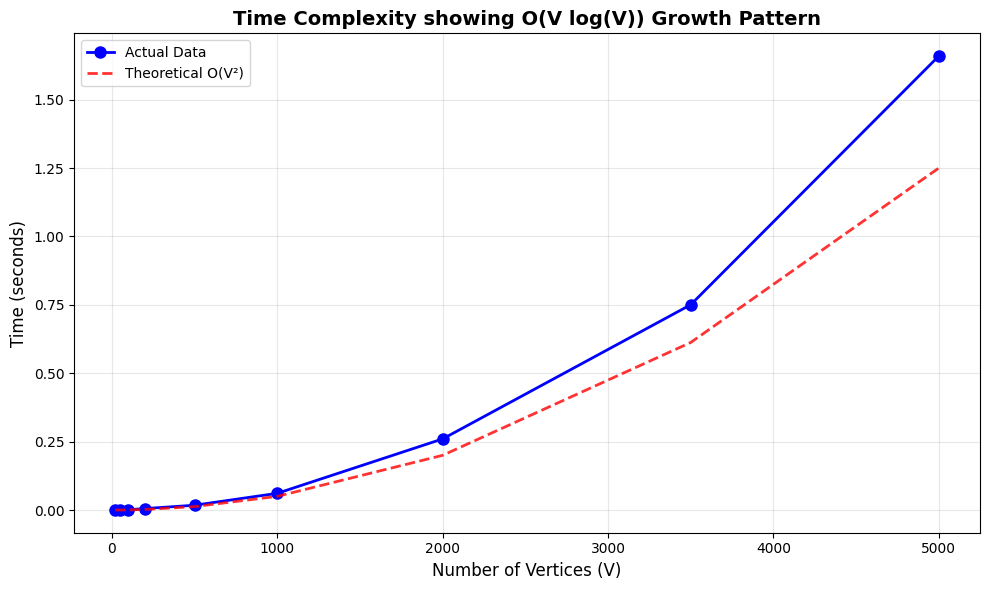

In [29]:

V_values = [item[0][0] for item in time_taken_result_for_sparse_heap]
time_values = [float(item[1]) for item in time_taken_result_for_sparse_heap]

#Create the plot
plt.figure(figsize=(10, 6))
plt.plot(V_values, time_values, 'b-o', linewidth=2, markersize=8, label='Actual Data') #actual

V_theoretical = np.array(V_values)
theoretical_times = (V_theoretical ** 2) * 0.00000005
plt.plot(V_theoretical, theoretical_times, 'r--', linewidth=2, 
         label='Theoretical O(V²)', alpha=0.8)
plt.xlabel('Number of Vertices (V)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time Complexity showing O(V log(V)) Growth Pattern', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()